# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [1]:
from cmdstanpy import CmdStanModel

import cmdstanpy
import arviz as az
import numpy as np
import scipy.stats as stats
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install --upgrade cmdstanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.31.0
Install directory: /root/.cmdstan
Download successful, file: /tmp/tmpcrv1f6tk
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.31.0
Building version cmdstan-2.31.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Test model compilation
Installed cmdstan-2.31.0


True

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [20]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

In [42]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

DEBUG:cmdstanpy:Removing /content/height_1_ppc
06:14:22 - cmdstanpy - INFO - compiling stan file /content/height_1_ppc.stan to exe file /content/height_1_ppc
INFO:cmdstanpy:compiling stan file /content/height_1_ppc.stan to exe file /content/height_1_ppc
DEBUG:cmdstanpy:cmd: make /content/height_1_ppc
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/height_1_ppc.hpp /content/height_1_ppc.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o 

chain 1 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_1_ppc', 'id=1', 'random', 'seed=29042020', 'output', 'file=/tmp/tmp5mrqwmvs/height_1_ppci8umnqas/height_1_ppc-20230413061437.csv', 'refresh=1000', 'method=sample', 'num_samples=1000', 'num_warmup=0', 'algorithm=fixed_param']


06:14:37 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/content/height_1_ppc', 'id=1', 'random', 'seed=29042020', 'output', 'file=/tmp/tmp5mrqwmvs/height_1_ppci8umnqas/height_1_ppc-20230413061437.csv', 'refresh=1000', 'method=sample', 'num_samples=1000', 'num_warmup=0', 'algorithm=fixed_param']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp5mrqwmvs/height_1_ppci8umnqas/height_1_ppc-20230413061437.csv
 console_msgs (if any):
	/tmp/tmp5mrqwmvs/height_1_ppci8umnqas/height_1_ppc-20230413061437_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Defau

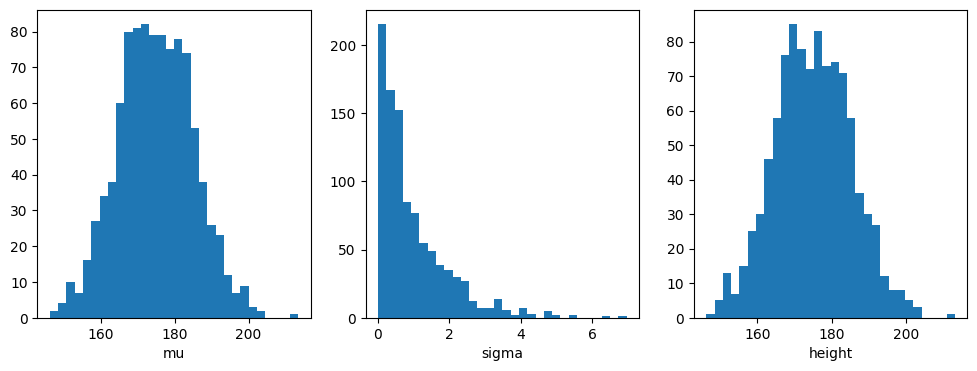

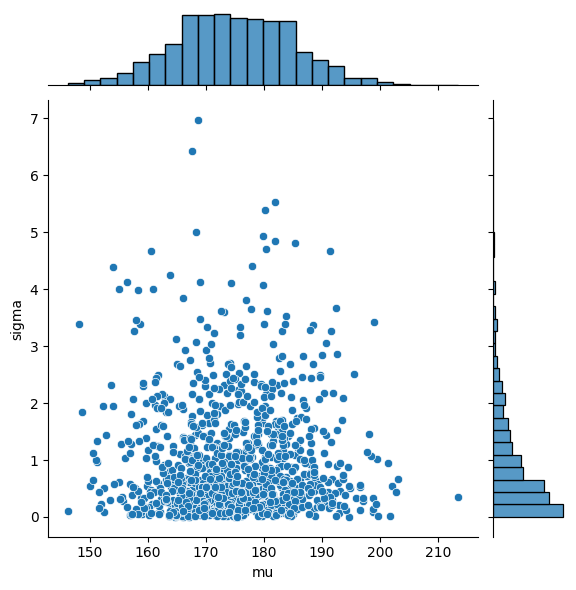

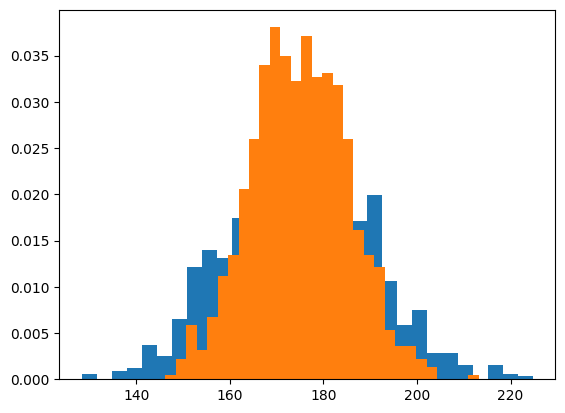

In [43]:
samples = sim.draws_pd()
mu_samples = samples["mu"]
sigma_samples = samples["sigma"]
height_samples = samples["height_sampled"]

# Plot histograms of the samples
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(mu_samples, bins=30)
axs[0].set_xlabel('mu')
axs[1].hist(sigma_samples, bins=30)
axs[1].set_xlabel('sigma')
axs[2].hist(height_samples, bins=30)
axs[2].set_xlabel('height')
plt.show()

# Plot a joint distribution of mu and sigma
import seaborn as sns

sns.jointplot(x="mu", y="sigma", data=samples)

# Check if samples are consistent with priors
data = np.random.normal(175, 15, size=1000)

_, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(data, bins=30, density=True)
ax.hist(height_samples, bins=30, density=True)
plt.show()





In [44]:
print(np.all(data >= np.percentile(height_samples, 2.5)) and np.all(data <= np.percentile(height_samples, 97.5)))

False




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

## Task 2. Model fit and evaluation

In [61]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

DEBUG:cmdstanpy:Removing /content/height_1_fit
06:24:01 - cmdstanpy - INFO - compiling stan file /content/height_1_fit.stan to exe file /content/height_1_fit
INFO:cmdstanpy:compiling stan file /content/height_1_fit.stan to exe file /content/height_1_fit
DEBUG:cmdstanpy:cmd: make /content/height_1_fit
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/height_1_fit.hpp /content/height_1_fit.stan
Warning in '/content/height_1_fit.stan', line 3, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_1_fit', 'id=1', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/x3x4h6i4.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_1_fitfqhpk6pa/height_1_fit-20230413062413_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_1_fit', 'id=2', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/x3x4h6i4.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_1_fitfqhpk6pa/height_1_fit-20230413062413_2.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_1_fit', 'id=3', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/x3x4h6i4.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_1_fitfqhpk6pa/height_1_fit-20230413062413_3.

06:24:13 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/height_1_fit', 'id=1', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/x3x4h6i4.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_1_fitfqhpk6pa/height_1_fit-20230413062413_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp5mrqwmvs/height_1_fitfqhpk6pa/height_1_fit-20230413062413_1.csv
 console_msgs (if any):
	/tmp/tmp5mrqwmvs/height_1_fitfqhpk6pa/height_1_fit-20230413062413_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.800000000

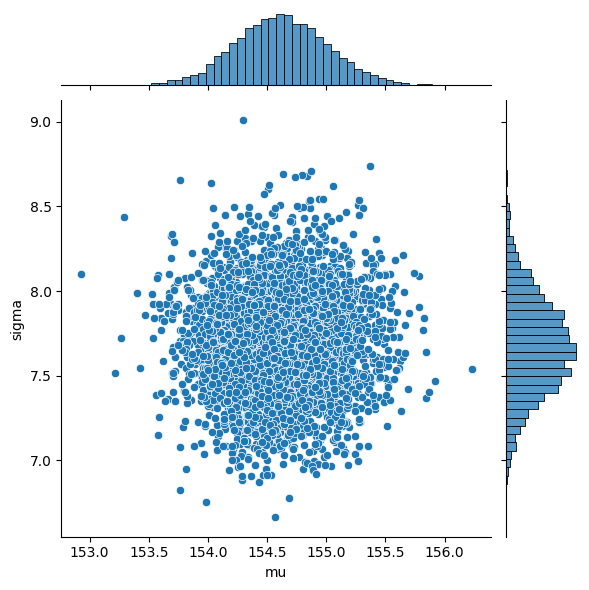

In [64]:
samples = fit.draws_pd()
mu_samples = samples["mu"]
sigma_samples = samples["sigma"]
height_samples = samples["height_samples"]

sns.jointplot(x="mu", y="sigma", data=samples)

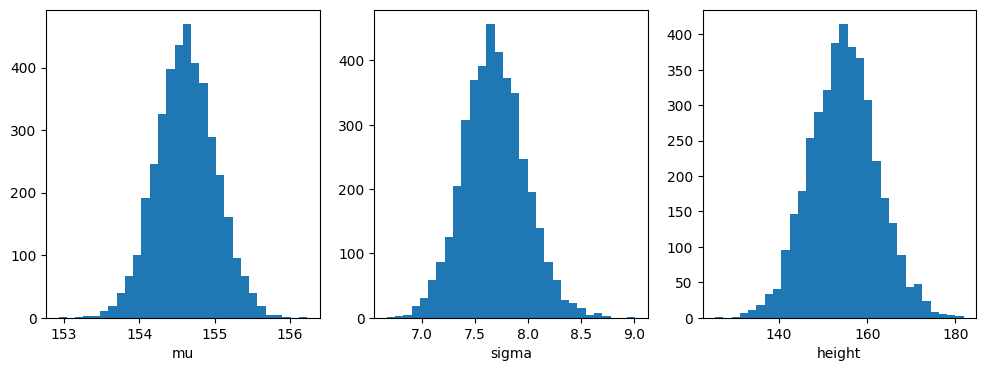

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(mu_samples, bins=30)
axs[0].set_xlabel('mu')
axs[1].hist(sigma_samples, bins=30)
axs[1].set_xlabel('sigma')
axs[2].hist(height_samples, bins=30)
axs[2].set_xlabel('height')
plt.show()

Better fit then using first model



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [66]:
mean = np.mean(d["height"])
d["c_weight"] = d["height"] - mean
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
print(data_sim)


{'N': 50, 'weight': array([-18.07209261, -17.20382731, -16.335562  , -15.4672967 ,
       -14.59903139, -13.73076608, -12.86250078, -11.99423547,
       -11.12597016, -10.25770486,  -9.38943955,  -8.52117425,
        -7.65290894,  -6.78464363,  -5.91637833,  -5.04811302,
        -4.17984772,  -3.31158241,  -2.4433171 ,  -1.5750518 ,
        -0.70678649,   0.16147881,   1.02974412,   1.89800943,
         2.76627473,   3.63454004,   4.50280535,   5.37107065,
         6.23933596,   7.10760126,   7.97586657,   8.84413188,
         9.71239718,  10.58066249,  11.44892779,  12.3171931 ,
        13.18545841,  14.05372371,  14.92198902,  15.79025433,
        16.65851963,  17.52678494,  18.39505024,  19.26331555,
        20.13158086,  20.99984616,  21.86811147,  22.73637677,
        23.60464208,  24.47290739])}


## Task 4. Prior predictive checks
 

In [67]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

06:26:08 - cmdstanpy - INFO - compiling stan file /content/height_2a_ppc.stan to exe file /content/height_2a_ppc
INFO:cmdstanpy:compiling stan file /content/height_2a_ppc.stan to exe file /content/height_2a_ppc
DEBUG:cmdstanpy:cmd: make /content/height_2a_ppc
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/height_2a_ppc.hpp /content/height_2a_ppc.stan
Warning in '/content/height_2a_ppc.stan', line 3, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/content/height_2a_ppc.stan', line 7, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed aut

chain 1 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2a_ppc', 'id=1', 'random', 'seed=29042020', 'data', 'file=/tmp/tmp5mrqwmvs/je6p6sfv.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2a_ppcfc7l8p1r/height_2a_ppc-20230413062619.csv', 'refresh=1000', 'method=sample', 'num_samples=1000', 'num_warmup=0', 'algorithm=fixed_param']


06:26:20 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/content/height_2a_ppc', 'id=1', 'random', 'seed=29042020', 'data', 'file=/tmp/tmp5mrqwmvs/je6p6sfv.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2a_ppcfc7l8p1r/height_2a_ppc-20230413062619.csv', 'refresh=1000', 'method=sample', 'num_samples=1000', 'num_warmup=0', 'algorithm=fixed_param']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp5mrqwmvs/height_2a_ppcfc7l8p1r/height_2a_ppc-20230413062619.csv
 console_msgs (if any):
	/tmp/tmp5mrqwmvs/height_2a_ppcfc7l8p1r/height_2a_ppc-20230413062619_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0

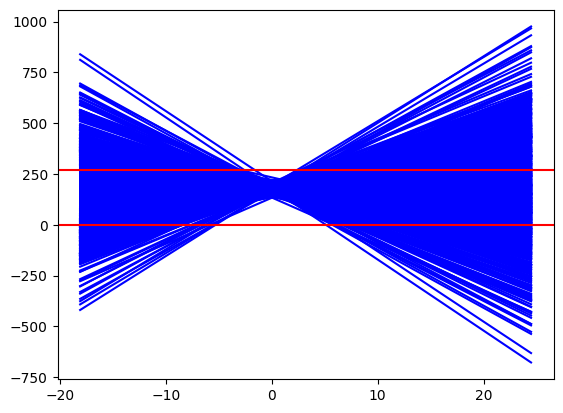

In [69]:
samples = sim.draws_pd()
alpha_samples = samples["alpha"]
beta_samples = samples["beta"]
# heights = samples["height"]

for i in range(len(alpha_samples)):
    plt.plot(data_sim['weight'], beta_samples[i] * data_sim['weight'] + alpha_samples[i], color='blue')

plt.axhline(y=0, color='red')
plt.axhline(y=272, color='red')
plt.show()

Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [70]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

06:29:07 - cmdstanpy - INFO - compiling stan file /content/height_2b_ppc.stan to exe file /content/height_2b_ppc
INFO:cmdstanpy:compiling stan file /content/height_2b_ppc.stan to exe file /content/height_2b_ppc
DEBUG:cmdstanpy:cmd: make /content/height_2b_ppc
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/height_2b_ppc.hpp /content/height_2b_ppc.stan
Warning in '/content/height_2b_ppc.stan', line 3, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/content/height_2b_ppc.stan', line 7, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed aut

In [71]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5mrqwmvs/d66b0vxh.json
DEBUG:cmdstanpy:cmd: /content/height_2b_ppc info
cwd: None
06:29:17 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2b_ppc', 'id=1', 'random', 'seed=29042020', 'data', 'file=/tmp/tmp5mrqwmvs/d66b0vxh.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2b_ppcmihuyrb5/height_2b_ppc-20230413062917.csv', 'refresh=1000', 'method=sample', 'num_samples=1000', 'num_warmup=0', 'algorithm=fixed_param']


06:29:18 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/content/height_2b_ppc', 'id=1', 'random', 'seed=29042020', 'data', 'file=/tmp/tmp5mrqwmvs/d66b0vxh.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2b_ppcmihuyrb5/height_2b_ppc-20230413062917.csv', 'refresh=1000', 'method=sample', 'num_samples=1000', 'num_warmup=0', 'algorithm=fixed_param']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp5mrqwmvs/height_2b_ppcmihuyrb5/height_2b_ppc-20230413062917.csv
 console_msgs (if any):
	/tmp/tmp5mrqwmvs/height_2b_ppcmihuyrb5/height_2b_ppc-20230413062917_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0

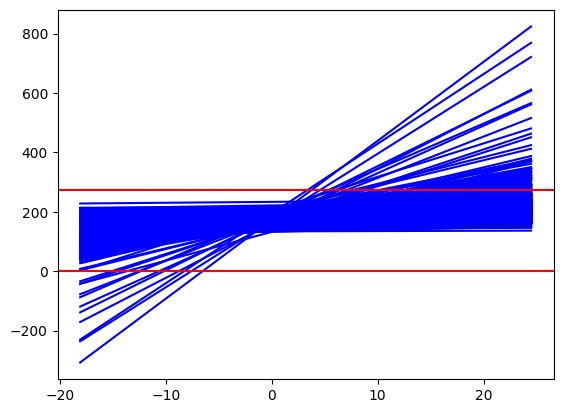

In [72]:
samples = sim.draws_pd()
alpha_samples = samples["alpha"]
beta_samples = samples["beta"]
# heights = samples["height"]

for i in range(len(alpha_samples)):
    plt.plot(data_sim['weight'], beta_samples[i] * data_sim['weight'] + alpha_samples[i], color='blue')

plt.axhline(y=0, color='red')
plt.axhline(y=272, color='red')
plt.show()

In [76]:
data = np.percentile(samples.filter(regex='^height').to_numpy(), [0, 5, 25, 50, 75, 95, 100], axis=0)
real_data = np.percentile(d.height, [0, 5, 25, 50, 75, 95, 100], axis=0)


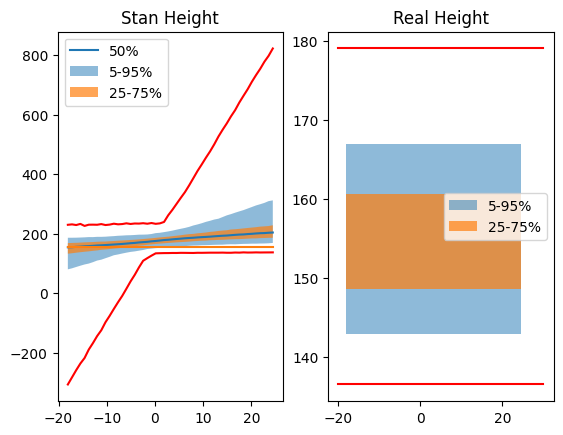

In [90]:
_, ax = plt.subplots(ncols=2, nrows=1)
ax[0].plot(data_sim['weight'], data[3], label='50%')
ax[0].fill_between(data_sim['weight'], data[1], data[5], alpha=0.5, label='5-95%')
ax[0].fill_between(data_sim['weight'], data[2], data[4], alpha=0.7, label='25-75%')
ax[0].plot(data_sim['weight'], data[0], 'red')
ax[0].plot(data_sim['weight'], data[-1], 'red')
ax[0].legend()
ax[0].set_title('Stan Height')


ax[0].plot(data_sim['weight'], [real_data[3]] * 50, label='50%')
ax[1].fill_between(data_sim['weight'], real_data[1], real_data[5], alpha=0.5, label='5-95%')
ax[1].fill_between(data_sim['weight'], real_data[2], real_data[4], alpha=0.7, label='25-75%')
ax[1].plot(np.linspace(-20,30), [real_data[0]] * 50, 'red' )
ax[1].plot(np.linspace(-20,30), [real_data[-1]] * 50, 'red' )
ax[1].legend()
ax[1].set_title('Real Height')
plt.show()

1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

## Task 6. Fitting and evaluating model


In [91]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

06:52:36 - cmdstanpy - INFO - compiling stan file /content/height_2_fit.stan to exe file /content/height_2_fit
INFO:cmdstanpy:compiling stan file /content/height_2_fit.stan to exe file /content/height_2_fit
DEBUG:cmdstanpy:cmd: make /content/height_2_fit
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/height_2_fit.hpp /content/height_2_fit.stan
Warning in '/content/height_2_fit.stan', line 4, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/content/height_2_fit.stan', line 25, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatical

In [108]:
N = 50
data={'N':N, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max(), num=N), 'heights':d.height.values[:N]}

1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [102]:
fit=model_2_fit.sample(data=data,seed=28052020)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp5mrqwmvs/onkj8aiu.json
DEBUG:cmdstanpy:cmd: /content/height_2_fit info
cwd: None
06:58:44 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=1', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/onkj8aiu.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit1pdxhx2n/height_2_fit-20230413065845_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=2', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/onkj8aiu.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit1pdxhx2n/height_2_fit-20230413065845_2.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=3', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/onkj8aiu.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit1pdxhx2n/height_2_fit-20230413065845_3.

06:58:45 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/height_2_fit', 'id=1', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/onkj8aiu.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit1pdxhx2n/height_2_fit-20230413065845_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp5mrqwmvs/height_2_fit1pdxhx2n/height_2_fit-20230413065845_1.csv
 console_msgs (if any):
	/tmp/tmp5mrqwmvs/height_2_fit1pdxhx2n/height_2_fit-20230413065845_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.800000000

2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


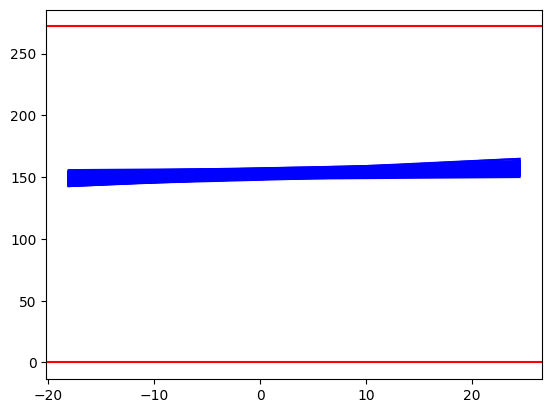

In [103]:
samples = fit.draws_pd()
alpha_samples = samples["alpha"]
beta_samples = samples["beta"]
# heights = samples["height"]

for i in range(len(alpha_samples)):
    plt.plot(data_sim['weight'], beta_samples[i] * data_sim['weight'] + alpha_samples[i], color='blue')

plt.axhline(y=0, color='red')
plt.axhline(y=272, color='red')
plt.show()

In [107]:
N = 100
data2={'N':N, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max(), num=N), 'heights':d.height.values[:N]}

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5mrqwmvs/pjrrf4_u.json
DEBUG:cmdstanpy:cmd: /content/height_2_fit info
cwd: None
06:59:00 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=2', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/pjrrf4_u.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit_kkxl5gl/height_2_fit-20230413065900_2.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=1', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/pjrrf4_u.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit_kkxl5gl/height_2_fit-20230413065900_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=3', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/pjrrf4_u.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit_kkxl5gl/height_2_fit-20230413065900_3.

06:59:02 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/height_2_fit', 'id=1', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/pjrrf4_u.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit_kkxl5gl/height_2_fit-20230413065900_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp5mrqwmvs/height_2_fit_kkxl5gl/height_2_fit-20230413065900_1.csv
 console_msgs (if any):
	/tmp/tmp5mrqwmvs/height_2_fit_kkxl5gl/height_2_fit-20230413065900_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.800000000

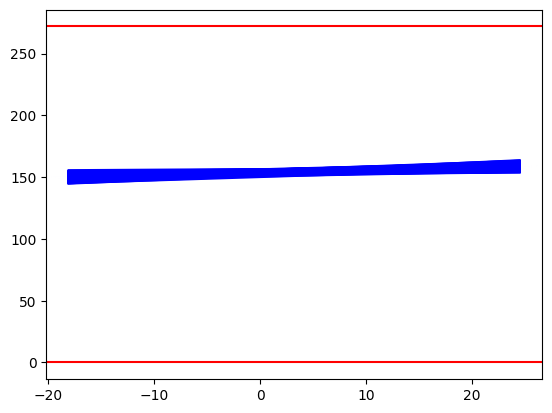

In [104]:
N = 100
data2={'N':N, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max(), num=N), 'heights':d.height.values[:N]}
fit2=model_2_fit.sample(data=data2, seed=28052020)


samples2 = fit2.draws_pd()
alpha_samples = samples2["alpha"]
beta_samples = samples2["beta"]
# heights = samples["height"]

for i in range(len(alpha_samples)):
    plt.plot(data_sim['weight'], beta_samples[i] * data_sim['weight'] + alpha_samples[i], color='blue')

plt.axhline(y=0, color='red')
plt.axhline(y=272, color='red')
plt.show()

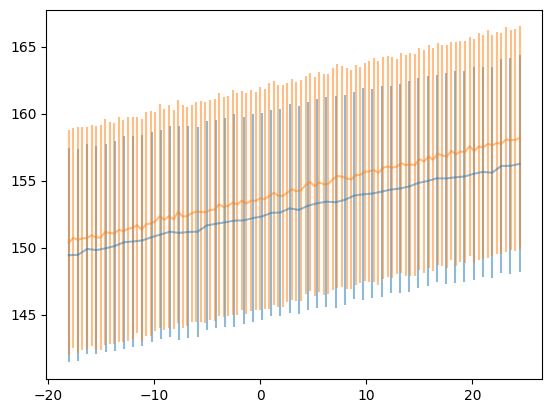

In [109]:
mean1, std1 = samples.iloc[:,-50:].mean(),  samples.iloc[:,-50:].std()
mean2, std2 = samples2.iloc[:,-100:].mean(), samples2.iloc[:,-100:].std()

plt.errorbar(x=data['weight'], y=mean1, yerr=std1, alpha=0.5)
plt.errorbar(x=data2['weight'], y=mean2, yerr=std2, alpha=0.5)
plt.show()

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5mrqwmvs/f3em5lot.json
DEBUG:cmdstanpy:cmd: /content/height_2_fit info
cwd: None
07:05:35 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=1', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/f3em5lot.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fito66sxkpr/height_2_fit-20230413070535_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=2', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/f3em5lot.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fito66sxkpr/height_2_fit-20230413070535_2.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=3', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/f3em5lot.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fito66sxkpr/height_2_fit-20230413070535_3.

07:05:36 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/height_2_fit', 'id=1', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/f3em5lot.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fito66sxkpr/height_2_fit-20230413070535_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp5mrqwmvs/height_2_fito66sxkpr/height_2_fit-20230413070535_1.csv
 console_msgs (if any):
	/tmp/tmp5mrqwmvs/height_2_fito66sxkpr/height_2_fit-20230413070535_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.800000000

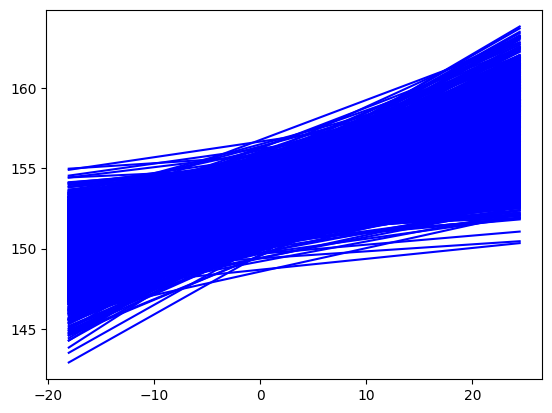

In [111]:
N = 50
weights = np.linspace(d.c_weight.min(), d.c_weight.max(), num=N)
weight = weights - weights.mean()
data_fit={'N':N, 'weight':weight, 'heights':d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit, seed=28052020)


samples = fit.draws_pd()
alpha_samples = samples["alpha"]
beta_samples = samples["beta"]
# heights = samples["height"]

for i in range(len(alpha_samples)):
    plt.plot(data_sim['weight'], beta_samples[i] * data_sim['weight'] + alpha_samples[i], color='blue')

plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmp5mrqwmvs/8u5yodsk.json
DEBUG:cmdstanpy:cmd: /content/height_2_fit info
cwd: None
07:06:37 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=1', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/8u5yodsk.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit85i7yg3y/height_2_fit-20230413070637_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=2', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/8u5yodsk.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit85i7yg3y/height_2_fit-20230413070637_2.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/height_2_fit', 'id=3', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/8u5yodsk.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit85i7yg3y/height_2_fit-20230413070637_3.

07:06:38 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/height_2_fit', 'id=1', 'random', 'seed=28052020', 'data', 'file=/tmp/tmp5mrqwmvs/8u5yodsk.json', 'output', 'file=/tmp/tmp5mrqwmvs/height_2_fit85i7yg3y/height_2_fit-20230413070637_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp5mrqwmvs/height_2_fit85i7yg3y/height_2_fit-20230413070637_1.csv
 console_msgs (if any):
	/tmp/tmp5mrqwmvs/height_2_fit85i7yg3y/height_2_fit-20230413070637_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.800000000

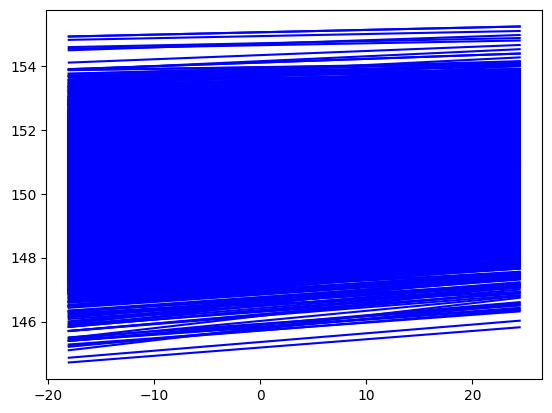

In [112]:
N = 50
weights = np.linspace(d.c_weight.min(), d.c_weight.max(), num=N)
weight = weights - weights.mean()
data_fit={'N':N, 'weight':weight**2, 'heights':d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit, seed=28052020)


samples = fit.draws_pd()
alpha_samples = samples["alpha"]
beta_samples = samples["beta"]
# heights = samples["height"]

for i in range(len(alpha_samples)):
    plt.plot(data_sim['weight'], beta_samples[i] * data_sim['weight'] + alpha_samples[i], color='blue')

plt.show()